<a href="https://colab.research.google.com/github/bhuvansun/rice-classification/blob/main/rice_classification_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>1 <span style='color:#E71414'>|</span> Importing libraries</b>
- **For DL Models**: tensorflow, keras
- **For Data Manipulation**: numpy, sklearn, PIL
- **For Data Visualization**: matplotlib, seaborn, plotly

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# For Data Processing & DL Models
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Miscellaneous
from tqdm import tqdm
import os
import random
import opendatasets as od

# Turn off warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# <b>2 <span style='color:#E71414'>| </span> Reading the Dataset</b>

In [ ]:
od.download('https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: thribhuvansunkavalli
Your Kaggle Key: ··········


100%|██████████| 219M/219M [00:10<00:00, 20.9MB/s]


In [ ]:
unique_labels = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

data_dir = './rice-image-dataset/Rice_Image_Dataset/'

all_paths = []
all_labels = []

for label in unique_labels:
    for image_path in os.listdir(data_dir+label):
        all_paths.append(data_dir+label+'/'+image_path)
        all_labels.append(label)
'''
An image of path all_paths[i] has the label all_labels[i], where i is an index
'''
all_paths, all_labels = shuffle(all_paths, all_labels)

In [ ]:
values = [len([x for x in all_labels if x==label]) for label in unique_labels]
fig = go.Figure(data=[go.Pie(labels=unique_labels, values=values, rotation=-45, hole=.3, textinfo='label+percent')])
fig.update_layout(showlegend=False)
fig.show()

#### The dataset is perfectly balanced

# <b>3 <span style='color:#E71414; font-weight: bold;'>|</span> Data Preprocessing</b>

<h2>3.1 <span style='color:#E71414; font-weight: bold;'>|</span> Train-Val Split</h2>

- 90% for training
- 10% for validation

In [ ]:
x_train_paths, x_val_paths, y_train, y_val = train_test_split(all_paths, all_labels,
                                                              test_size=0.1, random_state=42,
                                                              stratify=all_labels)

<h2>3.2 <span style='color:#E71414; font-weight: bold;'>|</span> Image Data Augmentation</h2>

- Random Brightness from 60% to 140%
- Random Contrast from 60% to 140%

In [ ]:
BRIGHTNESS = (0.6, 1.4)
CONTRAST   = (0.6, 1.4)

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(BRIGHTNESS[0],BRIGHTNESS[1]))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(CONTRAST[0],CONTRAST[1]))
    return image

<h2>3.3 <span style='color:#E71414; font-weight: bold;'>|</span> Label encoder-decoder</h2>

In [ ]:
def encode_labels(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_labels(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

<h2>3.4 <span style='color:#E71414; font-weight: bold;'>|</span> Load images</h2>

In [ ]:
IMAGE_SIZE = 96

In [ ]:
def open_images(paths, augment=True):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        if augment:
            image = augment_image(image)
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

Example usage of `open_images` function

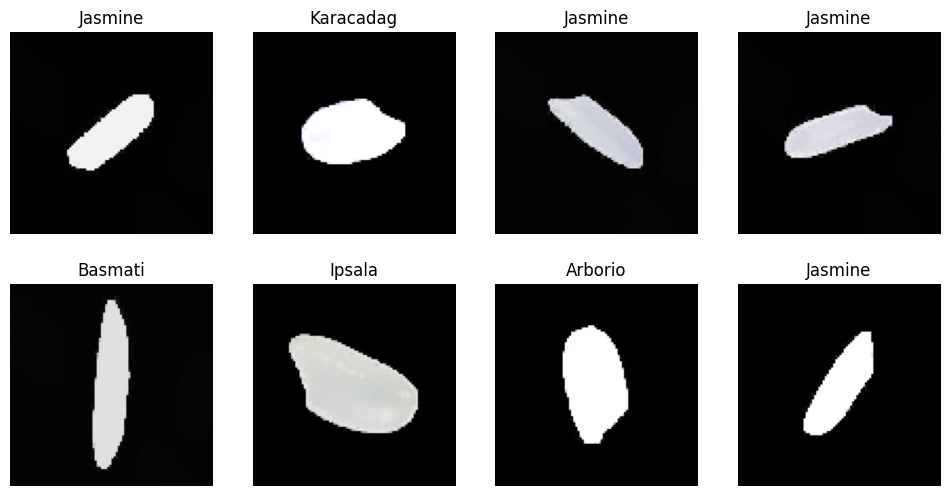

In [ ]:
# Load images and their labels
images = open_images(x_train_paths[50:59])
labels = y_train[50:59]

# Plot images with their labels
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.show()

<h2>3.5 <span style='color:#E71414; font-weight: bold;'>|</span> Data Generator</h2>
<p style="font-size:15px; line-height: 1.7em">
    Given a list of paths to images, and the labels, <br>
    this function augments the images, normalizes them, encodes the label, and then returns the batch on which the model can train on. <br>
</p>

In [ ]:
def datagen(paths, labels, batch_size=12, epochs=3, augment=True):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths, augment=augment)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_labels(batch_labels)
            yield batch_images, batch_labels

# <b>4 <span style='color:#E71414; font-weight: bold;'>|</span> Model</b>

<h2>4.1 <span style='color:#E71414; font-weight: bold;'>|</span> Build Model</h2>

<h3>I am using <span style = "color:#E71414; font-weight: normal;">VGG16</span> for transfer learning</h3>

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last VGG block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 15,895,877
Trainable params: 8,260,613
Non

<h2>4.2 <span style='color:#E71414; font-weight: bold;'>|</span> Compile Model</h2>

`SparseCategoricalCrossentropy` and `CategoricalCrossentropy` are basically the same loss functions, just their input formats are different.

$$\mathrm{Loss} = -\cfrac{1}{N}\sum_{i=1}^N [y_i\text{log}(\hat y_i) + (1-y_i)\text{log}(1-\hat y_i)]$$
where,
$\hat y$ is the predicted label, and $y$ is the actual label
$y_i$ is the $i^\mathbf{th}$ sample of $y$  and $\hat y_i$ is the $i^\mathbf{th}$ sample of $\hat y$
$N$ is the number of samples

If $y_i$ is **one-hot encoded**, we use `CategoricalCrossentropy`, and if $y_i$ is **integer-encoded**, we use `SparseCategoricalCrossentropy`

In our case, our labels are **integer-encoded**, so we are using `SparseCategoricalCrossentropy`

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

<h2>4.3 <span style='color:#E71414; font-weight: bold;'>|</span> Train Model</h2>

In [ ]:
batch_size = 64
steps = int(len(x_train_paths)/batch_size)
epochs = 5
history = model.fit(datagen(x_train_paths, y_train, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
1054/1054 [==============================] - 158s 137ms/step - loss: 0.0968 - sparse_categorical_accuracy: 0.9656
Epoch 2/5
1054/1054 [==============================] - 143s 134ms/step - loss: 0.0484 - sparse_categorical_accuracy: 0.9842
Epoch 3/5
1054/1054 [==============================] - 143s 135ms/step - loss: 0.0407 - sparse_categorical_accuracy: 0.9863
Epoch 4/5
1054/1054 [==============================] - 142s 135ms/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9876
Epoch 5/5
1054/1054 [==============================] - 143s 136ms/step - loss: 0.0338 - sparse_categorical_accuracy: 0.9890


<h2>4.4 <span style='color:#E71414; font-weight: bold;'>|</span> Evaluate Model</h2>

In [ ]:
batch_size=128
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(x_val_paths, y_val, batch_size=batch_size, epochs=1, augment=False), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_labels(pred):
        y_pred.append(i)
    for i in decode_labels(y):
        y_true.append(i)

  0%|          | 0/58 [00:00<?, ?it/s]

4/4 [==============================] - 1s 20ms/step


  2%|▏         | 1/58 [00:01<01:35,  1.67s/it]

4/4 [==============================] - 0s 24ms/step


  3%|▎         | 2/58 [00:01<00:48,  1.15it/s]

4/4 [==============================] - 0s 24ms/step


  5%|▌         | 3/58 [00:02<00:33,  1.65it/s]

4/4 [==============================] - 0s 24ms/step


  7%|▋         | 4/58 [00:02<00:27,  1.99it/s]

4/4 [==============================] - 0s 23ms/step


  9%|▊         | 5/58 [00:02<00:22,  2.32it/s]

4/4 [==============================] - 0s 24ms/step


 10%|█         | 6/58 [00:03<00:20,  2.59it/s]

4/4 [==============================] - 0s 24ms/step


 12%|█▏        | 7/58 [00:03<00:18,  2.75it/s]

4/4 [==============================] - 0s 24ms/step


 14%|█▍        | 8/58 [00:03<00:17,  2.85it/s]

4/4 [==============================] - 0s 25ms/step


 16%|█▌        | 9/58 [00:04<00:16,  2.98it/s]

4/4 [==============================] - 0s 25ms/step


 17%|█▋        | 10/58 [00:04<00:15,  3.07it/s]

4/4 [==============================] - 0s 24ms/step


 19%|█▉        | 11/58 [00:04<00:14,  3.15it/s]

4/4 [==============================] - 0s 24ms/step


 21%|██        | 12/58 [00:05<00:14,  3.19it/s]

4/4 [==============================] - 0s 24ms/step


 22%|██▏       | 13/58 [00:05<00:13,  3.22it/s]

4/4 [==============================] - 0s 24ms/step


 24%|██▍       | 14/58 [00:05<00:14,  3.12it/s]

4/4 [==============================] - 0s 24ms/step


 26%|██▌       | 15/58 [00:06<00:13,  3.18it/s]

4/4 [==============================] - 0s 24ms/step


 28%|██▊       | 16/58 [00:06<00:12,  3.24it/s]

4/4 [==============================] - 0s 24ms/step


 29%|██▉       | 17/58 [00:06<00:13,  3.14it/s]

4/4 [==============================] - 0s 24ms/step


 31%|███       | 18/58 [00:06<00:13,  3.08it/s]

4/4 [==============================] - 0s 25ms/step


 33%|███▎      | 19/58 [00:07<00:12,  3.04it/s]

4/4 [==============================] - 0s 25ms/step


 34%|███▍      | 20/58 [00:07<00:12,  3.00it/s]

4/4 [==============================] - 0s 25ms/step


 36%|███▌      | 21/58 [00:08<00:13,  2.76it/s]

4/4 [==============================] - 0s 27ms/step


 38%|███▊      | 22/58 [00:08<00:13,  2.60it/s]

4/4 [==============================] - 0s 26ms/step


 40%|███▉      | 23/58 [00:08<00:14,  2.47it/s]

4/4 [==============================] - 0s 24ms/step


 41%|████▏     | 24/58 [00:09<00:14,  2.39it/s]

4/4 [==============================] - 0s 27ms/step


 43%|████▎     | 25/58 [00:09<00:13,  2.36it/s]

4/4 [==============================] - 0s 25ms/step


 45%|████▍     | 26/58 [00:10<00:13,  2.39it/s]

4/4 [==============================] - 0s 24ms/step


 47%|████▋     | 27/58 [00:10<00:12,  2.57it/s]

4/4 [==============================] - 0s 25ms/step


 48%|████▊     | 28/58 [00:10<00:10,  2.77it/s]

4/4 [==============================] - 0s 24ms/step


 50%|█████     | 29/58 [00:11<00:10,  2.81it/s]

4/4 [==============================] - 0s 23ms/step


 52%|█████▏    | 30/58 [00:11<00:09,  2.97it/s]

4/4 [==============================] - 0s 24ms/step


 53%|█████▎    | 31/58 [00:11<00:09,  2.96it/s]

4/4 [==============================] - 0s 24ms/step


 55%|█████▌    | 32/58 [00:12<00:08,  3.09it/s]

4/4 [==============================] - 0s 25ms/step


 57%|█████▋    | 33/58 [00:12<00:07,  3.19it/s]

4/4 [==============================] - 0s 23ms/step


 59%|█████▊    | 34/58 [00:12<00:07,  3.24it/s]

4/4 [==============================] - 0s 24ms/step


 60%|██████    | 35/58 [00:13<00:06,  3.29it/s]

4/4 [==============================] - 0s 24ms/step


 62%|██████▏   | 36/58 [00:13<00:06,  3.32it/s]

4/4 [==============================] - 0s 25ms/step


 64%|██████▍   | 37/58 [00:13<00:06,  3.33it/s]

4/4 [==============================] - 0s 25ms/step


 66%|██████▌   | 38/58 [00:14<00:06,  3.14it/s]

4/4 [==============================] - 0s 24ms/step


 67%|██████▋   | 39/58 [00:14<00:06,  3.05it/s]

4/4 [==============================] - 0s 24ms/step


 69%|██████▉   | 40/58 [00:14<00:05,  3.05it/s]

4/4 [==============================] - 0s 24ms/step


 71%|███████   | 41/58 [00:15<00:05,  3.04it/s]

4/4 [==============================] - 0s 24ms/step


 72%|███████▏  | 42/58 [00:15<00:05,  3.00it/s]

4/4 [==============================] - 0s 24ms/step


 74%|███████▍  | 43/58 [00:15<00:04,  3.06it/s]

4/4 [==============================] - 0s 25ms/step


 76%|███████▌  | 44/58 [00:15<00:04,  3.14it/s]

4/4 [==============================] - 0s 23ms/step


 78%|███████▊  | 45/58 [00:16<00:04,  3.20it/s]

4/4 [==============================] - 0s 23ms/step


 79%|███████▉  | 46/58 [00:16<00:03,  3.12it/s]

4/4 [==============================] - 0s 24ms/step


 81%|████████  | 47/58 [00:16<00:03,  3.08it/s]

4/4 [==============================] - 0s 24ms/step


 83%|████████▎ | 48/58 [00:17<00:03,  3.15it/s]

4/4 [==============================] - 0s 24ms/step


 84%|████████▍ | 49/58 [00:17<00:02,  3.11it/s]

4/4 [==============================] - 0s 24ms/step


 86%|████████▌ | 50/58 [00:17<00:02,  3.16it/s]

4/4 [==============================] - 0s 24ms/step


 88%|████████▊ | 51/58 [00:18<00:02,  3.21it/s]

4/4 [==============================] - 0s 24ms/step


 90%|████████▉ | 52/58 [00:18<00:01,  3.27it/s]

4/4 [==============================] - 0s 24ms/step


 91%|█████████▏| 53/58 [00:18<00:01,  3.32it/s]

4/4 [==============================] - 0s 24ms/step


 93%|█████████▎| 54/58 [00:19<00:01,  3.34it/s]

4/4 [==============================] - 0s 25ms/step


 95%|█████████▍| 55/58 [00:19<00:00,  3.31it/s]

4/4 [==============================] - 0s 24ms/step


 97%|█████████▋| 56/58 [00:19<00:00,  3.28it/s]

4/4 [==============================] - 0s 24ms/step


 98%|█████████▊| 57/58 [00:20<00:00,  3.19it/s]

4/4 [==============================] - 0s 25ms/step


100%|██████████| 58/58 [00:20<00:00,  3.20it/s]

3/3 [==============================] - 1s 324ms/step


59it [00:21,  2.69it/s]


In [ ]:
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

     Arborio      0.994     0.997     0.995      1500
     Basmati      0.999     0.992     0.996      1500
      Ipsala      0.999     0.998     0.998      1500
     Jasmine      0.989     0.997     0.993      1500
   Karacadag      0.999     0.996     0.997      1500

    accuracy                          0.996      7500
   macro avg      0.996     0.996     0.996      7500
weighted avg      0.996     0.996     0.996      7500



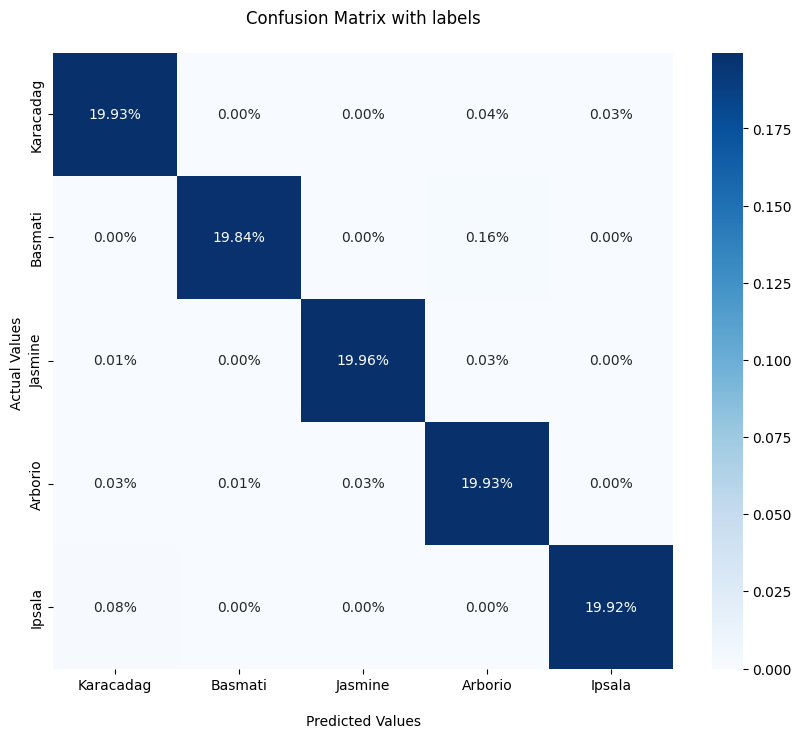

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(unique_labels)
ax.yaxis.set_ticklabels(unique_labels)

plt.show()

# <b>5 <span style='color:#E71414; font-weight: bold;'>|</span> Inference</b>

In [ ]:
def predict(images):
    pred = model.predict(images)
    pred = np.argmax(pred, axis=-1)
    pred = decode_labels(pred)
    return pred

1/1 [==============================] - 0s 465ms/step


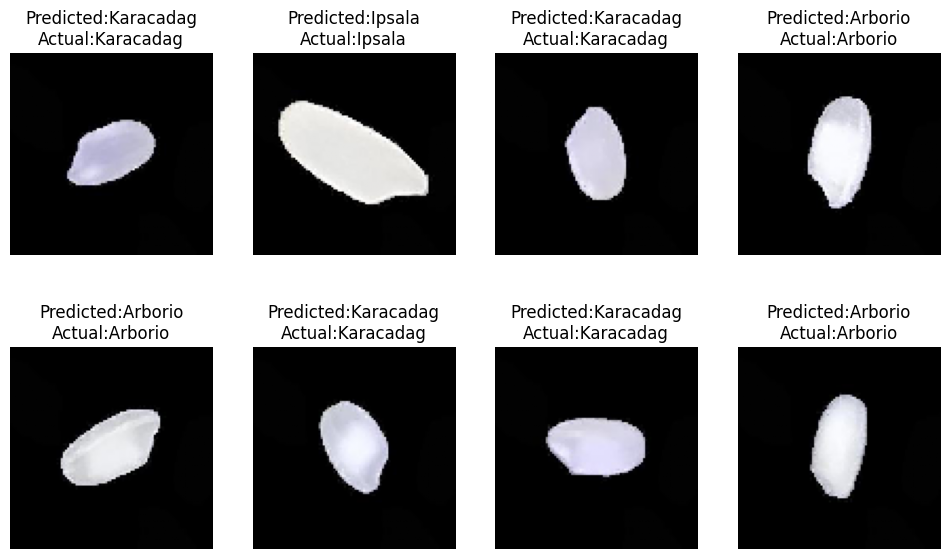

In [ ]:
NUM_IMAGES = 8
idx = random.sample(range(len(y_val)), NUM_IMAGES)

labels = [y_val[x] for x in idx]
image_paths = [x_val_paths[x] for x in idx]
images = open_images(image_paths, augment=False)
pred = predict(images)

cols = 4
rows = 2
fig = plt.figure(figsize=(12, 7))

for x in range(NUM_IMAGES):
    fig.add_subplot(rows, cols, x+1)
    plt.axis('off')
    plt.title('Predicted:'+str(labels[x])+'\nActual:'+str(labels[x]))
    plt.imshow(images[x])
plt.show()